### Creating a simple CNN model for learning embeddings 

In [55]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
# show the progress bar while priting
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt

class CNN(nn.Module):
    
    def __init__(self, input_channels=1, embedding_dim=128):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.AdaptiveMaxPool1d(10)
        )
        self.flatten = nn.Flatten()

        self.embedding_layer = nn.Sequential(
            nn.Linear(64 * 10, embedding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_dim)
        )

        self.forecaster = nn.Sequential(
            nn.Linear(embedding_dim, 96)
        )

    def forward(self, x,  return_embedding=False):
        x = x.permute(0, 2, 1)
        feats = self.feature_extractor(x)
        flats = self.flatten(feats)
        embedding_output = self.embedding_layer(flats)
        pred = self.forecaster(embedding_output)

        if return_embedding:
            return embedding_output

        
        return pred

In [56]:

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

feature_extractor_model = CNN()
feature_extractor_model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(feature_extractor_model.parameters(), lr=0.001)

# data loading 
TARGET_DATASET = "etth1"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64

dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"

target_columns = ['OT']
# observable_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}
tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config)

print("Length of train, validation and target", len(dset_train), len(dset_valid), len(dset_test))

mps
Length of train, validation and target 8033 2785 2785


In [57]:
def create_feats_target(dset):
    
    features = []
    target = []
    for i in range(len(dset)):
        feats = dset[i]["past_values"]
        targ_sample = dset[i]["future_values"]
        features.append(feats)
        target.append(targ_sample)

    return np.array(features), np.array(target)
    
def set_random_seed(seed=42):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [58]:
x_train, y_train = create_feats_target(dset_train)
x_val, y_val = create_feats_target(dset_valid)
x_test, y_test = create_feats_target(dset_test)

# convert to torch tensors from numpy arrays
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

#convert to torch dataset
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

BATCH_SIZE = 64

# turn dataset into iterables
train_dataloader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x41e469810>,
 <torch.utils.data.dataloader.DataLoader at 0x41e468520>)

In [59]:

set_random_seed(33)

n_epochs = 20

for epoch in range(n_epochs):

    #  training
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        feature_extractor_model.train()

        
        data = X.to(device)
        # print(data.device)
        # print(data.shape)
        target = y.to(device)
        # print(target.device)
        # print(target.shape)
        optimizer.zero_grad()
        output = feature_extractor_model(data)
        # print(output.device)
        # print(output.shape)
        loss = criterion(output, target.squeeze(-1))  
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 

    
    train_loss /= len(train_dataloader)

    # Testing loop
    test_loss = 0
    feature_extractor_model.eval()

    with torch.inference_mode():

        for batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # print(X_test.shape)
            # print(y_test.shape)
            # 1. forward pass
            test_pred = feature_extractor_model.forward(X_test)
            
            loss = criterion(test_pred, y_test.squeeze(-1))
            # print(loss)
            test_loss += loss.item()
            

    test_loss /= len(test_dataloader)

    #print loss
    if epoch % 1 == 0:
        # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss.item()))
        print(f"Epoch: {epoch} \tTrain loss : {train_loss:.4f} | Test loss : {test_loss:.4f}")

    

    


Epoch: 0 	Train loss : 0.1982 | Test loss : 0.1957
Epoch: 1 	Train loss : 0.1138 | Test loss : 0.3240
Epoch: 2 	Train loss : 0.0945 | Test loss : 0.2055
Epoch: 3 	Train loss : 0.0833 | Test loss : 0.2632
Epoch: 4 	Train loss : 0.0800 | Test loss : 0.2207
Epoch: 5 	Train loss : 0.0744 | Test loss : 0.1930
Epoch: 6 	Train loss : 0.0674 | Test loss : 0.2433
Epoch: 7 	Train loss : 0.0673 | Test loss : 0.1943
Epoch: 8 	Train loss : 0.0694 | Test loss : 0.2184
Epoch: 9 	Train loss : 0.0623 | Test loss : 0.1475
Epoch: 10 	Train loss : 0.0630 | Test loss : 0.1985
Epoch: 11 	Train loss : 0.0578 | Test loss : 0.1845
Epoch: 12 	Train loss : 0.0578 | Test loss : 0.2135
Epoch: 13 	Train loss : 0.0613 | Test loss : 0.1766
Epoch: 14 	Train loss : 0.0599 | Test loss : 0.1888
Epoch: 15 	Train loss : 0.0550 | Test loss : 0.1762
Epoch: 16 	Train loss : 0.0566 | Test loss : 0.1710
Epoch: 17 	Train loss : 0.0554 | Test loss : 0.2186
Epoch: 18 	Train loss : 0.0523 | Test loss : 0.1691
Epoch: 19 	Train loss 

In [60]:
# model evaluation

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):

  """returns a dictionary containing the results of model predicting on data loaders"""
  loss = 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X, y = X.to(device), y.to(device)

      # make prediction
      y_pred = model(X)
      # print(y_pred.shape)

      # accumulate loss and acc per batch
      loss += loss_fn(y_pred, y.squeeze(-1))
      

    # scale the loss to find avg loss per batch
    loss /= len(data_loader)
    

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item()}


In [61]:
model_0_results = eval_model(model= feature_extractor_model,
                     data_loader=val_dataloader,
                     loss_fn = criterion,
                    device= "mps")
model_0_results

100%|██████████| 44/44 [00:00<00:00, 397.79it/s]


{'model_name': 'CNN', 'model_loss': 0.20338429510593414}

In [62]:
# extracting validation set embeddings
emb_val = feature_extractor_model(x_val.to(device), return_embedding=True)
emb_val = emb_val.detach().cpu().numpy()

In [63]:
# extracting test set embeddings
emb_test = feature_extractor_model(x_test.to(device), return_embedding=True)
emb_test = emb_test.detach().cpu().numpy()

(128,)
Explained variation for first two principal components : [0.6629813  0.06475077]


/var/folders/_c/7m63m9jd673fm9k_k08qtqj00000gn/T/ipykernel_28202/2530793006.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


Text(0.5, 1.0, 'Embeddings using feature extractor CNN model')

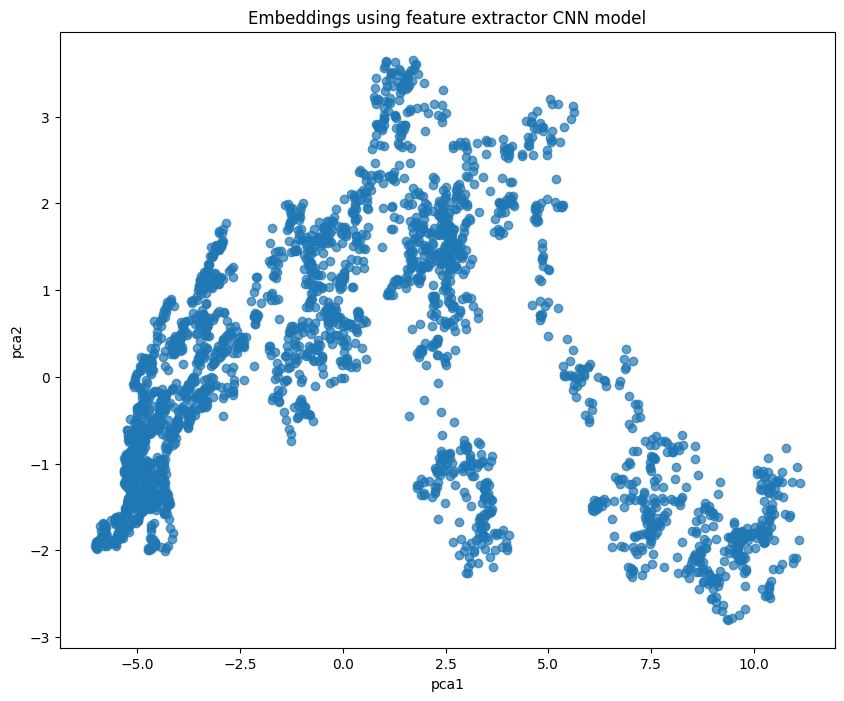

In [64]:
from sklearn.decomposition import PCA

pca_df = pd.DataFrame(emb_val,  columns=[f"dim_{i+1}" for i in range(emb_val.shape[1])])
pca_df.columns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_df)
print(pca_df.columns.shape)

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1] 
print('Explained variation for first two principal components : {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_df["pca1"], 
    pca_df["pca2"], 
    # c=pca_df["error"],   
    cmap="bwr", 
    alpha=0.7
)
# plt.colorbar(label="MSE per sample")
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.title(f"Embeddings using feature extractor CNN model")

Explained variation for first two principal components : [0.8015519  0.04433876]


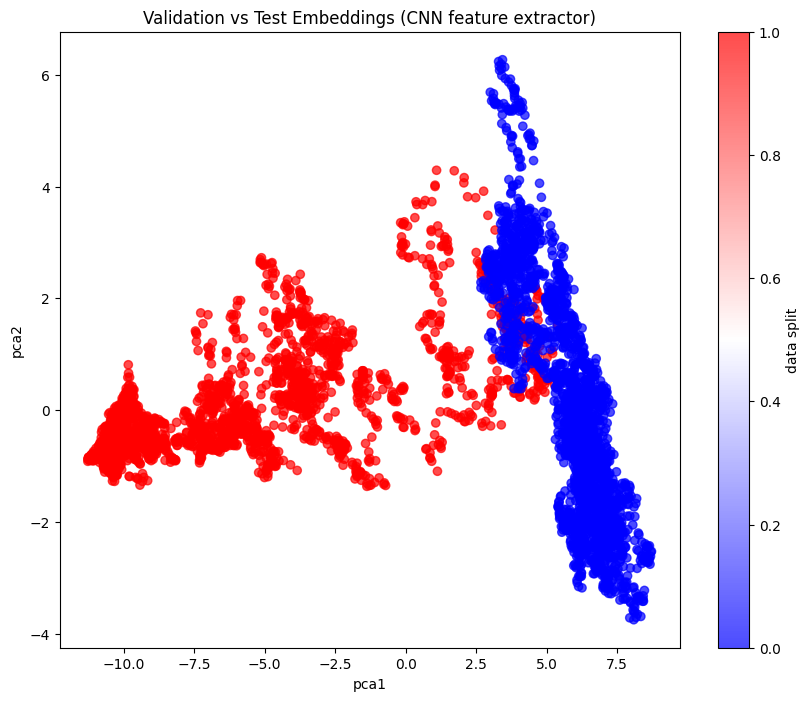

In [65]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

le = LabelEncoder()

# Combine embeddings
combined_embeddings = np.vstack((emb_val, emb_test))

# Create labels
val_labels = ['validation'] * len(emb_val)
test_labels = ['test'] * len(emb_test)
combined_labels = np.array(val_labels + test_labels)

# Create DataFrame
pca_c_df = pd.DataFrame(
    combined_embeddings,
    columns=[f"dim_{i+1}" for i in range(combined_embeddings.shape[1])]
)
pca_c_df['label'] = combined_labels
pca_c_df['label_encoded'] = le.fit_transform(pca_c_df['label'])

# PCA on numeric columns only
pca = PCA(n_components=2)
pca_comb_result = pca.fit_transform(
    pca_c_df.drop(columns=['label', 'label_encoded'])
)

# Add PCA components
pca_c_df['pca1'] = pca_comb_result[:, 0]
pca_c_df['pca2'] = pca_comb_result[:, 1]

print('Explained variation for first two principal components :',
      pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(
    pca_c_df["pca1"],
    pca_c_df["pca2"],
    c=pca_c_df["label_encoded"],
    cmap="bwr",
    alpha=0.7
)
plt.colorbar(label="data split")
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.title("Validation vs Test Embeddings (CNN feature extractor)")
plt.show()


In [66]:
pca_c_df

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,...,dim_123,dim_124,dim_125,dim_126,dim_127,dim_128,label,label_encoded,pca1,pca2
0,-0.504019,-0.528823,-0.780681,-0.789365,-0.740549,-1.429389,-0.924911,-0.602126,-0.596233,-1.144379,...,-0.00882,-0.002337,-0.519248,-0.511446,-0.929895,-0.510252,validation,1,-9.126968,-0.307510
1,-0.504019,-0.528823,-0.780681,-0.789365,-0.740549,-1.473235,-0.924911,-0.602126,-0.631814,-1.141025,...,-0.00882,-0.002337,-0.519248,-0.511446,-0.954143,-0.510252,validation,1,-9.144636,-0.340612
2,-0.504019,-0.528823,-0.780681,-0.789365,-0.740549,-1.467480,-0.924911,-0.602126,-0.632692,-1.142976,...,-0.00882,-0.002337,-0.519248,-0.511446,-0.965349,-0.510252,validation,1,-9.124668,-0.345343
3,-0.504019,-0.528823,-0.780681,-0.789365,-0.740549,-1.483506,-0.924911,-0.602126,-0.636770,-1.138674,...,-0.00882,-0.002337,-0.519248,-0.511446,-0.964833,-0.510252,validation,1,-9.141676,-0.357669
4,-0.504019,-0.528823,-0.780681,-0.789365,-0.740549,-1.516750,-0.924911,-0.602126,-0.635215,-1.131642,...,-0.00882,-0.002337,-0.519248,-0.511446,-1.011620,-0.510252,validation,1,-9.163141,-0.345269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,-0.504019,-0.528823,2.484871,1.799283,1.752403,0.772488,-0.507829,-0.409490,-0.695331,1.227964,...,-0.00882,-0.002337,-0.519248,-0.511446,1.119862,-0.510252,test,0,6.790756,-2.061469
5566,-0.504019,-0.528823,2.478001,1.687126,1.638430,0.768355,-0.509777,-0.492992,-0.695331,1.194832,...,-0.00882,-0.002337,-0.519248,-0.511446,1.096496,-0.510252,test,0,6.681501,-2.095574
5567,-0.504019,-0.528823,2.420158,1.643386,1.669099,0.755415,-0.513511,-0.506914,-0.695331,1.189305,...,-0.00882,-0.002337,-0.519248,-0.511446,1.090895,-0.510252,test,0,6.595836,-2.109711
5568,-0.504019,-0.528823,2.430541,1.684559,1.668092,0.769096,-0.519674,-0.487786,-0.695331,1.212848,...,-0.00882,-0.002337,-0.519248,-0.511446,1.085097,-0.510252,test,0,6.614039,-2.114440


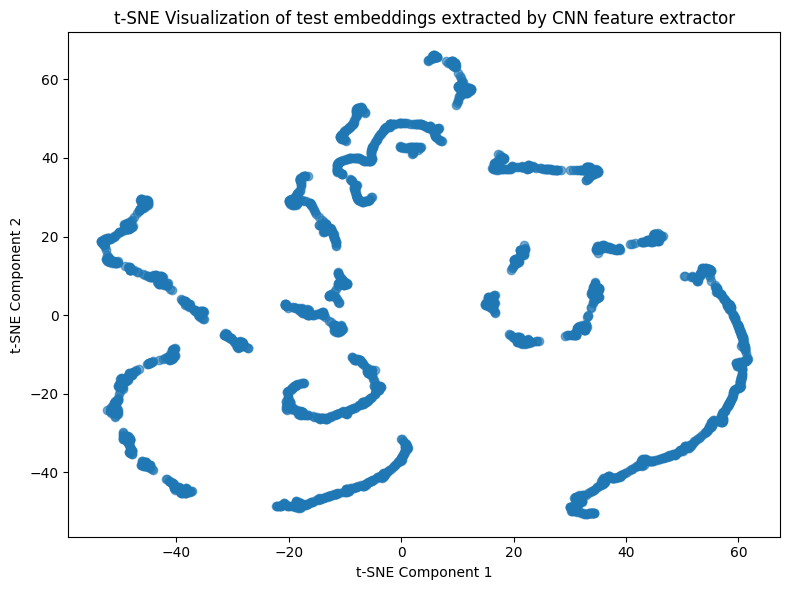

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=50, 
            learning_rate=300, max_iter=2000, random_state=33)
ft_embeddings_2d = tsne.fit_transform(emb_val)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(ft_embeddings_2d[:, 0], ft_embeddings_2d[:, 1], alpha=0.6) #c=targeted_val_df["error"],cmap='bwr'
# plt.colorbar(scatter)
plt.title('t-SNE Visualization of test embeddings extracted by CNN feature extractor')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

In [ ]:
### Code for model selection or discarding the samples at test time based on similarity

test_similarity_dict={}
drop_limit = 0.1 * len(dset_test)
test_distances = np.zeroes((len(dset_test), len(shapelet_dict_v3)))

# save all the test distances with shapelets in an array
for i in range(len(dset_test)):
    for j, shapelet in enumerate(shapelet_dict_v3.values()):
        dist = fastdtw(dset_test[i]["past_values"], shapelet)[0]
        test_distances[i, j] = dist


min_dists = test_distances.min(axis=1)
sorted_idx = np.argsort(min_dists)
selected_samples = sorted_idx[:targeted_samples]

dset_train_targeted = Subset(dset_train, selected_samples)
